# StyleForward Retail - Operational Efficiency Analysis
## Understanding What's Happening vs. Why It's Happening

### Executive Overview
This analysis examines StyleForward's operational efficiency through two lenses:
1. **Descriptive Analysis**: What is currently happening in our operations
2. **Diagnostic Analysis**: Why these patterns exist and what opportunities they reveal

### Key Business Questions to Answer:
- **Q7:** What would be the revenue impact of implementing BOPIS and ship-from-store?
- **Q8:** How much revenue is lost due to stockouts?
- **Q9:** What is the optimal inventory allocation between warehouse and stores?

## Section 1: Data Ingestion
### Loading all operational and supporting datasets

In [55]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [56]:
# Load all required CSV files
print("="*80)
print("DATA INGESTION - LOADING OPERATIONAL DATASETS")
print("="*80)

DATA_FILES = 'data/'

customers = pd.read_csv(DATA_FILES + 'customers.csv')
transactions = pd.read_csv(DATA_FILES + 'transactions_v2.csv')
transaction_items = pd.read_csv(DATA_FILES + 'transaction_items_v2.csv')
customer_touchpoints = pd.read_csv(DATA_FILES + 'customer_touchpoints_v2.csv')
marketing_campaigns = pd.read_csv(DATA_FILES + 'marketing_campaigns.csv')
marketing_spend = pd.read_csv(DATA_FILES + 'marketing_spend.csv')
products = pd.read_csv(DATA_FILES + 'products.csv')
stores = pd.read_csv(DATA_FILES + 'stores.csv')
inventory_snapshots = pd.read_csv(DATA_FILES + 'inventory_snapshots.csv')


# Create dataset dictionary
datasets = {
    'inventory_snapshots': inventory_snapshots,
    'stores': stores,
    'products': products,
    'transactions': transactions,
    'transaction_items': transaction_items,
    'customers': customers,
    'customer_touchpoints': customer_touchpoints,
    'marketing_campaigns': marketing_campaigns,
    'marketing_spend': marketing_spend
}

# Display dataset information
print("\nDatasets loaded successfully:")
print("-" * 50)
for name, df in datasets.items():
    print(f"{name:25} {df.shape[0]:6,} rows × {df.shape[1]:2} columns")

DATA INGESTION - LOADING OPERATIONAL DATASETS

Datasets loaded successfully:
--------------------------------------------------
inventory_snapshots           30 rows × 10 columns
stores                        15 rows ×  9 columns
products                      30 rows × 10 columns
transactions                  45 rows × 16 columns
transaction_items             54 rows ×  7 columns
customers                     31 rows × 13 columns
customer_touchpoints          27 rows × 17 columns
marketing_campaigns           30 rows × 10 columns
marketing_spend               30 rows ×  9 columns


In [57]:
# Normalize column headers to lower case

def lower_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip().lower() for c in df.columns]
    return df

# Apply to all loaded datasets
for name, df in datasets.items():
    datasets[name] = lower_cols(df)

# Refresh top-level variables to point to updated dataframes
for name, df in datasets.items():
    globals()[name] = df

# Quick sanity check and confirmation output
for name, df in datasets.items():
    assert all(isinstance(c, str) and c == c.lower() for c in df.columns), f"{name} has non-lowercase headers"
print("All dataframe headers normalized to lowercase.")

All dataframe headers normalized to lowercase.


## Section 2: Data Cleaning
### Comprehensive data preparation with validation

In [58]:
# 2.1 CHECK FOR DUPLICATES
print("="*80)
print("DATA CLEANING - DUPLICATE DETECTION")
print("="*80)

duplicate_summary = []
for name, df in datasets.items():
    dup_count = df.duplicated().sum()
    duplicate_summary.append([name, dup_count, len(df), f"{dup_count/len(df)*100:.2f}%"])
    
    if dup_count > 0:
        print(f"\n {name}: Found {dup_count} duplicates")
        datasets[name] = df.drop_duplicates()
        print(f"    Removed {dup_count} duplicate rows")

# Display duplicate summary
dup_df = pd.DataFrame(duplicate_summary, columns=['Dataset', 'Duplicates', 'Total Rows', '% Duplicates'])
print("\nDuplicate Summary:")
print(dup_df.to_string(index=False))

# Update references
for name, df in datasets.items():
    globals()[name] = df

DATA CLEANING - DUPLICATE DETECTION

 customers: Found 1 duplicates
    Removed 1 duplicate rows

Duplicate Summary:
             Dataset  Duplicates  Total Rows % Duplicates
 inventory_snapshots           0          30        0.00%
              stores           0          15        0.00%
            products           0          30        0.00%
        transactions           0          45        0.00%
   transaction_items           0          54        0.00%
           customers           1          31        3.23%
customer_touchpoints           0          27        0.00%
 marketing_campaigns           0          30        0.00%
     marketing_spend           0          30        0.00%


In [59]:
# 2.2 FINDING AND REPLACING MISSING VALUES
print("="*80)
print("DATA CLEANING - MISSING VALUE HANDLING")
print("="*80)

missing_summary = []
for name, df in datasets.items():
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n{name} - Missing values found:")
        for col in missing[missing > 0].index:
            count = missing[col]
            pct = count/len(df)*100
            missing_summary.append([name, col, count, f"{pct:.1f}%"])
            print(f"  {col}: {count} missing ({pct:.1f}%)")
        
        # Apply specific handling strategies
        if name == 'inventory_snapshots':
            df['store_id'] = df['store_id'].fillna(0)  # 0 = warehouse
            print("  → Filled store_id NaN with 0 (warehouse)")
            
        elif name == 'transactions':
            df['store_id'] = df['store_id'].fillna(-1)  # -1 = online
            print("  → Filled store_id NaN with -1 (online)")
            
        elif name == 'customer_touchpoints':
            df['campaign_id'] = df['campaign_id'].fillna(-1)  # -1 = organic
            df['store_id'] = df['store_id'].fillna(-1)  # -1 = online
            df['pages_viewed'] = df['pages_viewed'].fillna(df['pages_viewed'].median())
            print("  → Applied context-specific imputation")
        
        datasets[name] = df

# Update all references
for name, df in datasets.items():
    globals()[name] = df

if missing_summary:
    print("\nMissing Value Summary:")
    missing_df = pd.DataFrame(missing_summary, columns=['Dataset', 'Column', 'Count', 'Percentage'])
    print(missing_df.to_string(index=False))
else:
    print("\n✓ No missing values found in any dataset")

DATA CLEANING - MISSING VALUE HANDLING

inventory_snapshots - Missing values found:
  store_id: 8 missing (26.7%)
  → Filled store_id NaN with 0 (warehouse)

transactions - Missing values found:
  store_id: 29 missing (64.4%)
  card_bank: 41 missing (91.1%)
  shipping_amount: 3 missing (6.7%)
  promo_code_used: 26 missing (57.8%)
  device_type: 16 missing (35.6%)
  → Filled store_id NaN with -1 (online)

customer_touchpoints - Missing values found:
  campaign_id: 12 missing (44.4%)
  referrer_source: 5 missing (18.5%)
  landing_page: 8 missing (29.6%)
  pages_viewed: 8 missing (29.6%)
  products_viewed: 7 missing (25.9%)
  transaction_id: 8 missing (29.6%)
  device_type: 5 missing (18.5%)
  store_id: 22 missing (81.5%)
  → Applied context-specific imputation

Missing Value Summary:
             Dataset          Column  Count Percentage
 inventory_snapshots        store_id      8      26.7%
        transactions        store_id     29      64.4%
        transactions       card_bank     4

In [60]:
# 2.3 DATA TYPE CORRECTIONS (Numeric to Categorical)
print("="*80)
print("DATA CLEANING - DATA TYPE CONVERSIONS")
print("="*80)

# Convert store_id from numeric to categorical (it's an identifier, not a measure)
print("\n1. Converting store_id from numeric to categorical:")
print(f"   Before conversion: {inventory_snapshots['store_id'].dtype}")

for df_name in ['inventory_snapshots', 'transactions', 'customer_touchpoints']:
    if 'store_id' in datasets[df_name].columns:
        datasets[df_name]['store_id'] = datasets[df_name]['store_id'].astype('category')
        print(f"    {df_name}: converted to {datasets[df_name]['store_id'].dtype}")

# Convert date columns to datetime
print("\n2. Converting date columns to datetime:")
date_conversions = [
    ('inventory_snapshots', 'snapshot_date'),
    ('products', 'launch_date'),
    ('stores', 'opened_date'),
    ('transactions', 'order_date'),
    ('transaction_items', None),  # No date columns
    ('customers', 'acquisition_date'),
    ('customer_touchpoints', 'touchpoint_timestamp'),
    ('marketing_campaigns', 'start_date'),
    ('marketing_campaigns', 'end_date'),
    ('marketing_spend', 'spend_date')
]

for dataset_name, col in date_conversions:
    if col and col in datasets[dataset_name].columns:
        datasets[dataset_name][col] = pd.to_datetime(datasets[dataset_name][col])
        print(f"    {dataset_name}.{col} converted")

# Update all global references
for name, df in datasets.items():
    globals()[name] = df

DATA CLEANING - DATA TYPE CONVERSIONS

1. Converting store_id from numeric to categorical:
   Before conversion: float64
    inventory_snapshots: converted to category
    transactions: converted to category
    customer_touchpoints: converted to category

2. Converting date columns to datetime:
    inventory_snapshots.snapshot_date converted
    products.launch_date converted
    stores.opened_date converted
    transactions.order_date converted
    customers.acquisition_date converted
    customer_touchpoints.touchpoint_timestamp converted
    marketing_campaigns.start_date converted
    marketing_campaigns.end_date converted
    marketing_spend.spend_date converted


In [61]:
# 2.4 COLUMN NAME CHANGES
print("="*80)
print("DATA CLEANING - COLUMN RENAMING")
print("="*80)

print("\nRenaming columns for clarity and consistency:")

# Inventory snapshots - shorten lengthy names
inventory_snapshots.rename(columns={
    'quantity_available': 'qty_available',
    'quantity_reserved': 'qty_reserved'
}, inplace=True)
print("  inventory_snapshots:")
print("    'quantity_available' → 'qty_available'")
print("    'quantity_reserved' → 'qty_reserved'")

# Stores - make more descriptive
stores.rename(columns={
    'square_footage': 'store_size_sqft'
}, inplace=True)
print("  stores:")
print("    'square_footage' → 'store_size_sqft'")

datasets['inventory_snapshots'] = inventory_snapshots
datasets['stores'] = stores

DATA CLEANING - COLUMN RENAMING

Renaming columns for clarity and consistency:
  inventory_snapshots:
    'quantity_available' → 'qty_available'
    'quantity_reserved' → 'qty_reserved'
  stores:
    'square_footage' → 'store_size_sqft'


DATA CLEANING - CATEGORICAL DATA ANALYSIS



1. Store Type Distribution:
   Unique values (nunique): 4
   Unique list: ['Flagship', 'Standard', 'Outlet', 'Pop-up']
   Value counts:
     Standard: 7
     Flagship: 3
     Outlet: 3
     Pop-up: 2

2. Product Category Distribution:
   Unique values (nunique): 4
   Unique list: ['Apparel', 'Footwear', 'Accessories', 'Electronics']
   Value counts:
     Accessories: 13
     Apparel: 12
     Footwear: 3
     Electronics: 2

3. Fulfillment Method Analysis (with cleaning):
   Original unique values: ['Ship', 'In-Store', 'BOPIS']
   After cleaning: ['ship', 'in-store', 'bopis']
   Value counts:
     ship: 24
     in-store: 16
     bopis: 5

4. Inventory Location Types:
   Unique values (nunique): 2
   Value counts:
     Store: 22
     Warehouse: 8

5. Transaction Channel Distribution (with cleaning):
   Original values: ['Online', 'Store', 'Mobile App']
   After cleaning: ['online', 'store', 'mobile app']
   Value counts:
     online: 20
     store: 16
     mobile app: 9

6. Stockout Fla

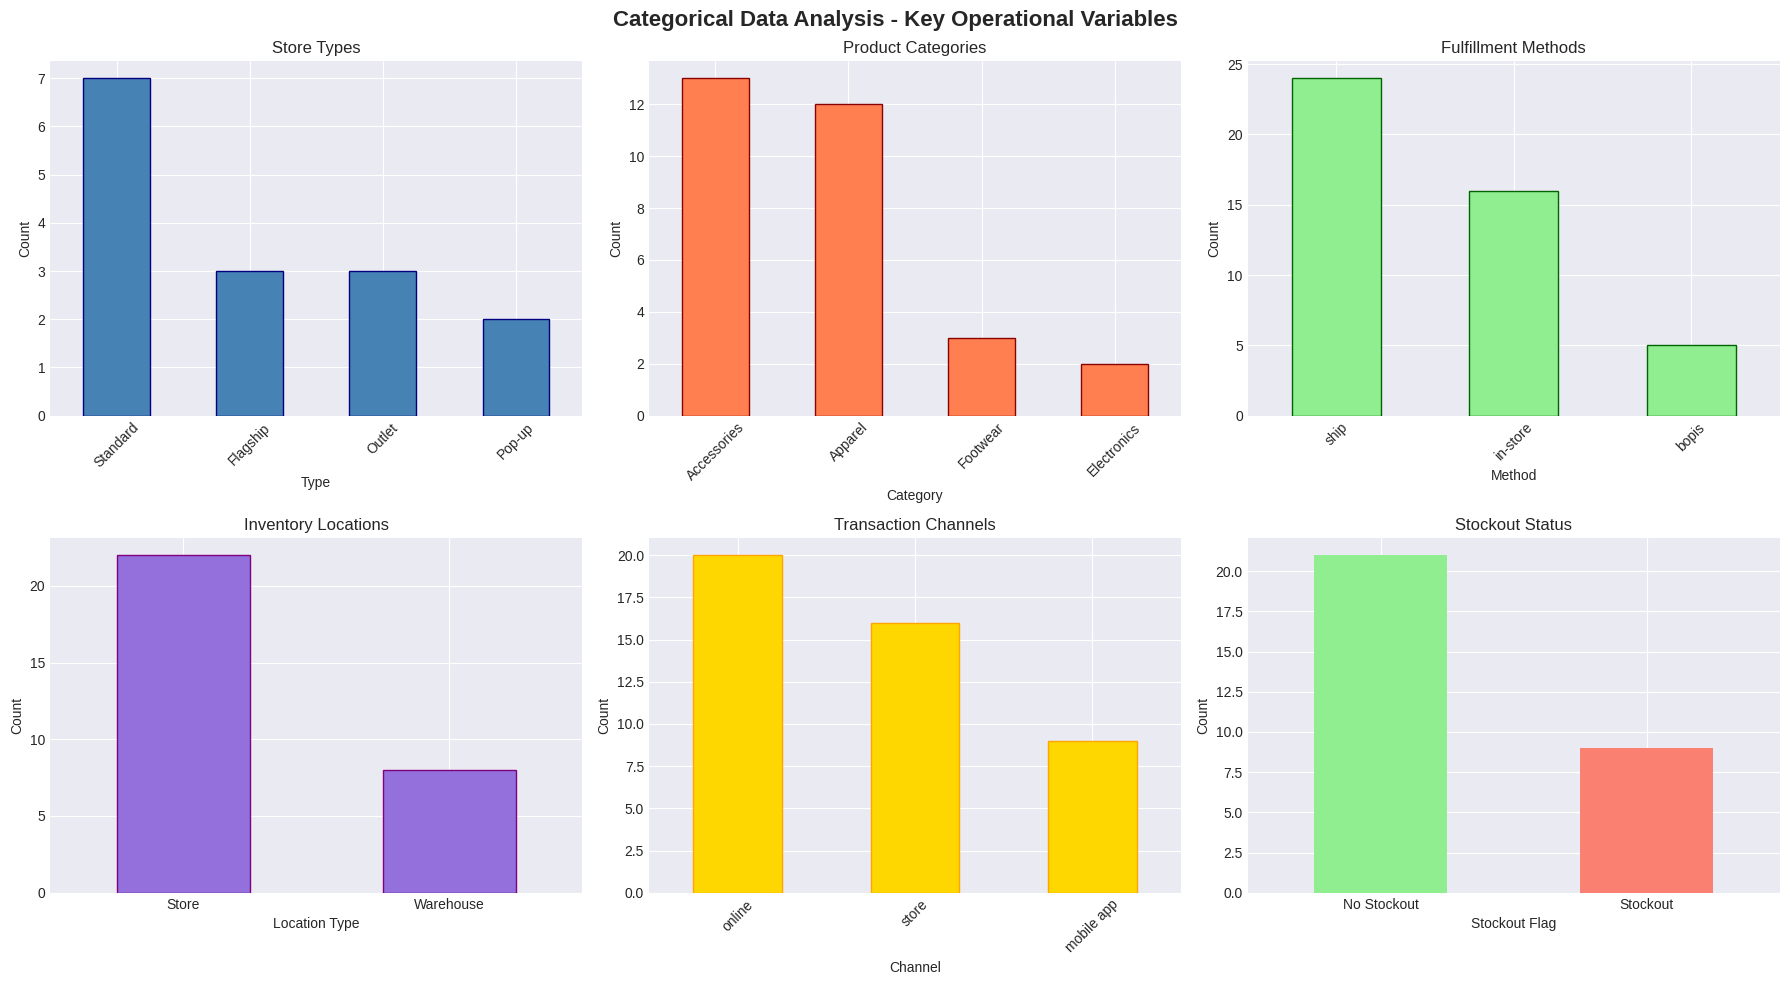

In [62]:
# 2.5 CATEGORICAL DATA ANALYSIS WITH BAR CHARTS
print("="*80)
print("DATA CLEANING - CATEGORICAL DATA ANALYSIS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Categorical Data Analysis - Key Operational Variables', fontsize=16, fontweight='bold')

# 1. Store Types
print("\n1. Store Type Distribution:")
store_types = stores['store_type'].value_counts()
print(f"   Unique values (nunique): {stores['store_type'].nunique()}")
print(f"   Unique list: {stores['store_type'].unique().tolist()}")
print("   Value counts:")
for val, count in store_types.items():
    print(f"     {val}: {count}")

ax1 = axes[0, 0]
store_types.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='navy')
ax1.set_title('Store Types')
ax1.set_xlabel('Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# 2. Product Categories
print("\n2. Product Category Distribution:")
categories = products['category'].value_counts()
print(f"   Unique values (nunique): {products['category'].nunique()}")
print(f"   Unique list: {products['category'].unique().tolist()}")
print("   Value counts:")
for val, count in categories.items():
    print(f"     {val}: {count}")

ax2 = axes[0, 1]
categories.plot(kind='bar', ax=ax2, color='coral', edgecolor='darkred')
ax2.set_title('Product Categories')
ax2.set_xlabel('Category')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# 3. Fulfillment Methods (with inconsistency fixing)
print("\n3. Fulfillment Method Analysis (with cleaning):")
print(f"   Original unique values: {transactions['fulfillment_method'].unique().tolist()}")

# Fix inconsistencies
transactions['fulfillment_method'] = transactions['fulfillment_method'].str.lower().str.strip()
transactions['fulfillment_method'] = transactions['fulfillment_method'].replace({
    'ship_to_home': 'ship-to-home',
    'in_store_pickup': 'store-pickup',
    'in-store_pickup': 'store-pickup'
})

print(f"   After cleaning: {transactions['fulfillment_method'].unique().tolist()}")
fulfillment = transactions['fulfillment_method'].value_counts()
print("   Value counts:")
for val, count in fulfillment.items():
    print(f"     {val}: {count}")

ax3 = axes[0, 2]
fulfillment.plot(kind='bar', ax=ax3, color='lightgreen', edgecolor='darkgreen')
ax3.set_title('Fulfillment Methods')
ax3.set_xlabel('Method')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

# 4. Location Types
print("\n4. Inventory Location Types:")
locations = inventory_snapshots['location_type'].value_counts()
print(f"   Unique values (nunique): {inventory_snapshots['location_type'].nunique()}")
print("   Value counts:")
for val, count in locations.items():
    print(f"     {val}: {count}")

ax4 = axes[1, 0]
locations.plot(kind='bar', ax=ax4, color='mediumpurple', edgecolor='purple')
ax4.set_title('Inventory Locations')
ax4.set_xlabel('Location Type')
ax4.set_ylabel('Count')
ax4.tick_params(axis='x', rotation=0)

# 5. Transaction Channels (with fixing)
print("\n5. Transaction Channel Distribution (with cleaning):")
print(f"   Original values: {transactions['channel'].unique().tolist()}")
transactions['channel'] = transactions['channel'].str.lower().str.strip()
print(f"   After cleaning: {transactions['channel'].unique().tolist()}")

channels = transactions['channel'].value_counts()
print("   Value counts:")
for val, count in channels.items():
    print(f"     {val}: {count}")

ax5 = axes[1, 1]
channels.plot(kind='bar', ax=ax5, color='gold', edgecolor='orange')
ax5.set_title('Transaction Channels')
ax5.set_xlabel('Channel')
ax5.set_ylabel('Count')
ax5.tick_params(axis='x', rotation=45)

# 6. Stockout Status
print("\n6. Stockout Flag Distribution:")
stockouts = inventory_snapshots['stockout_flag'].value_counts()
print(f"   Unique values: {inventory_snapshots['stockout_flag'].unique().tolist()}")
print("   Value counts:")
print(f"     No Stockout: {stockouts.get(False, 0)}")
print(f"     Stockout: {stockouts.get(True, 0)}")
print(f"   Stockout rate: {stockouts.get(True, 0)/len(inventory_snapshots)*100:.1f}%")

ax6 = axes[1, 2]
stockouts.plot(kind='bar', ax=ax6, color=['lightgreen', 'salmon'])
ax6.set_title('Stockout Status')
ax6.set_xlabel('Stockout Flag')
ax6.set_ylabel('Count')
ax6.set_xticklabels(['No Stockout', 'Stockout'], rotation=0)

plt.tight_layout()
plt.show()

DATA CLEANING - NUMERIC DATA ANALYSIS

1. Inventory Quantity on Hand:
   Mean: 69.73 units
   Median: 12 units
   Std Dev: 139.29 units
   Min: 0 units
   Max: 500 units

2. Days of Supply:
   Mean: 10.9 days
   Median: 6 days
   Std Dev: 16.3 days
   Min: 0 days
   Max: 60 days

3. Transaction Total Amounts:
   Mean: $111.24
   Median: $93.99
   Std Dev: $62.41
   Min: $16.01
   Max: $344.37

1. Inventory Quantity on Hand:
   Mean: 69.73 units
   Median: 12 units
   Std Dev: 139.29 units
   Min: 0 units
   Max: 500 units

2. Days of Supply:
   Mean: 10.9 days
   Median: 6 days
   Std Dev: 16.3 days
   Min: 0 days
   Max: 60 days

3. Transaction Total Amounts:
   Mean: $111.24
   Median: $93.99
   Std Dev: $62.41
   Min: $16.01
   Max: $344.37


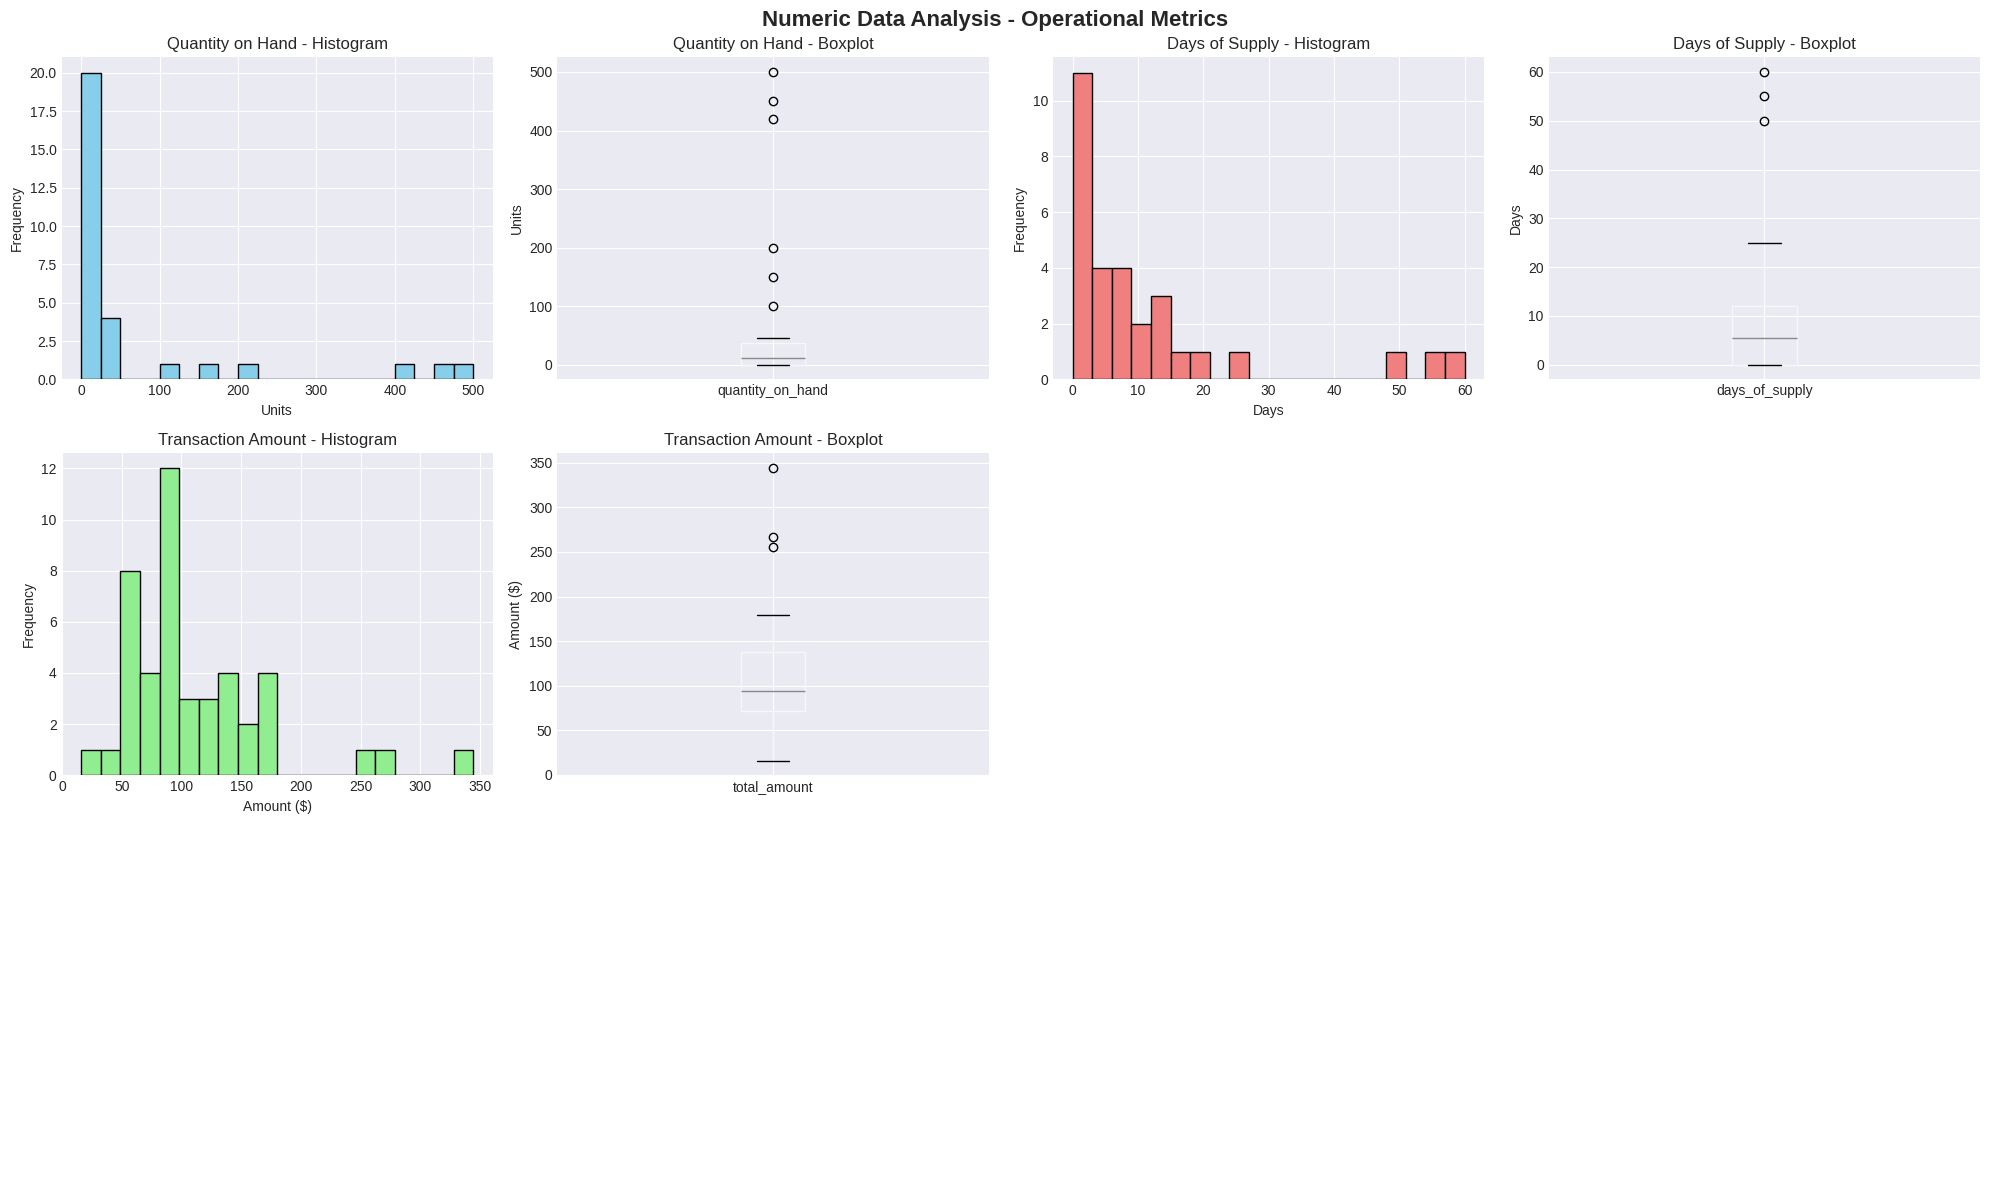

In [63]:
# 2.6 NUMERIC DATA ANALYSIS WITH HISTOGRAMS AND BOXPLOTS
print("="*80)
print("DATA CLEANING - NUMERIC DATA ANALYSIS")
print("="*80)

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.suptitle('Numeric Data Analysis - Operational Metrics', fontsize=16, fontweight='bold')

# 1. Inventory Quantity on Hand
print("\n1. Inventory Quantity on Hand:")
print(f"   Mean: {inventory_snapshots['quantity_on_hand'].mean():.2f} units")
print(f"   Median: {inventory_snapshots['quantity_on_hand'].median():.0f} units")
print(f"   Std Dev: {inventory_snapshots['quantity_on_hand'].std():.2f} units")
print(f"   Min: {inventory_snapshots['quantity_on_hand'].min():.0f} units")
print(f"   Max: {inventory_snapshots['quantity_on_hand'].max():.0f} units")

ax1 = axes[0, 0]
inventory_snapshots['quantity_on_hand'].hist(bins=20, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Quantity on Hand - Histogram')
ax1.set_xlabel('Units')
ax1.set_ylabel('Frequency')

ax2 = axes[0, 1]
inventory_snapshots.boxplot(column='quantity_on_hand', ax=ax2)
ax2.set_title('Quantity on Hand - Boxplot')
ax2.set_ylabel('Units')

# 2. Days of Supply
print("\n2. Days of Supply:")
print(f"   Mean: {inventory_snapshots['days_of_supply'].mean():.1f} days")
print(f"   Median: {inventory_snapshots['days_of_supply'].median():.0f} days")
print(f"   Std Dev: {inventory_snapshots['days_of_supply'].std():.1f} days")
print(f"   Min: {inventory_snapshots['days_of_supply'].min():.0f} days")
print(f"   Max: {inventory_snapshots['days_of_supply'].max():.0f} days")

ax3 = axes[0, 2]
inventory_snapshots['days_of_supply'].hist(bins=20, ax=ax3, color='lightcoral', edgecolor='black')
ax3.set_title('Days of Supply - Histogram')
ax3.set_xlabel('Days')
ax3.set_ylabel('Frequency')

ax4 = axes[0, 3]
inventory_snapshots.boxplot(column='days_of_supply', ax=ax4)
ax4.set_title('Days of Supply - Boxplot')
ax4.set_ylabel('Days')

# 3. Transaction Amounts
print("\n3. Transaction Total Amounts:")
print(f"   Mean: ${transactions['total_amount'].mean():.2f}")
print(f"   Median: ${transactions['total_amount'].median():.2f}")
print(f"   Std Dev: ${transactions['total_amount'].std():.2f}")
print(f"   Min: ${transactions['total_amount'].min():.2f}")
print(f"   Max: ${transactions['total_amount'].max():.2f}")

ax5 = axes[1, 0]
transactions['total_amount'].hist(bins=20, ax=ax5, color='lightgreen', edgecolor='black')
ax5.set_title('Transaction Amount - Histogram')
ax5.set_xlabel('Amount ($)')
ax5.set_ylabel('Frequency')

ax6 = axes[1, 1]
transactions.boxplot(column='total_amount', ax=ax6)
ax6.set_title('Transaction Amount - Boxplot')
ax6.set_ylabel('Amount ($)')

# Hide unused subplots
for i in range(6, 12):
    axes.flat[i].axis('off')

plt.tight_layout()
plt.show()

DATA CLEANING - PAIR PLOT ANALYSIS

Creating pair plot to examine relationships between key operational metrics...


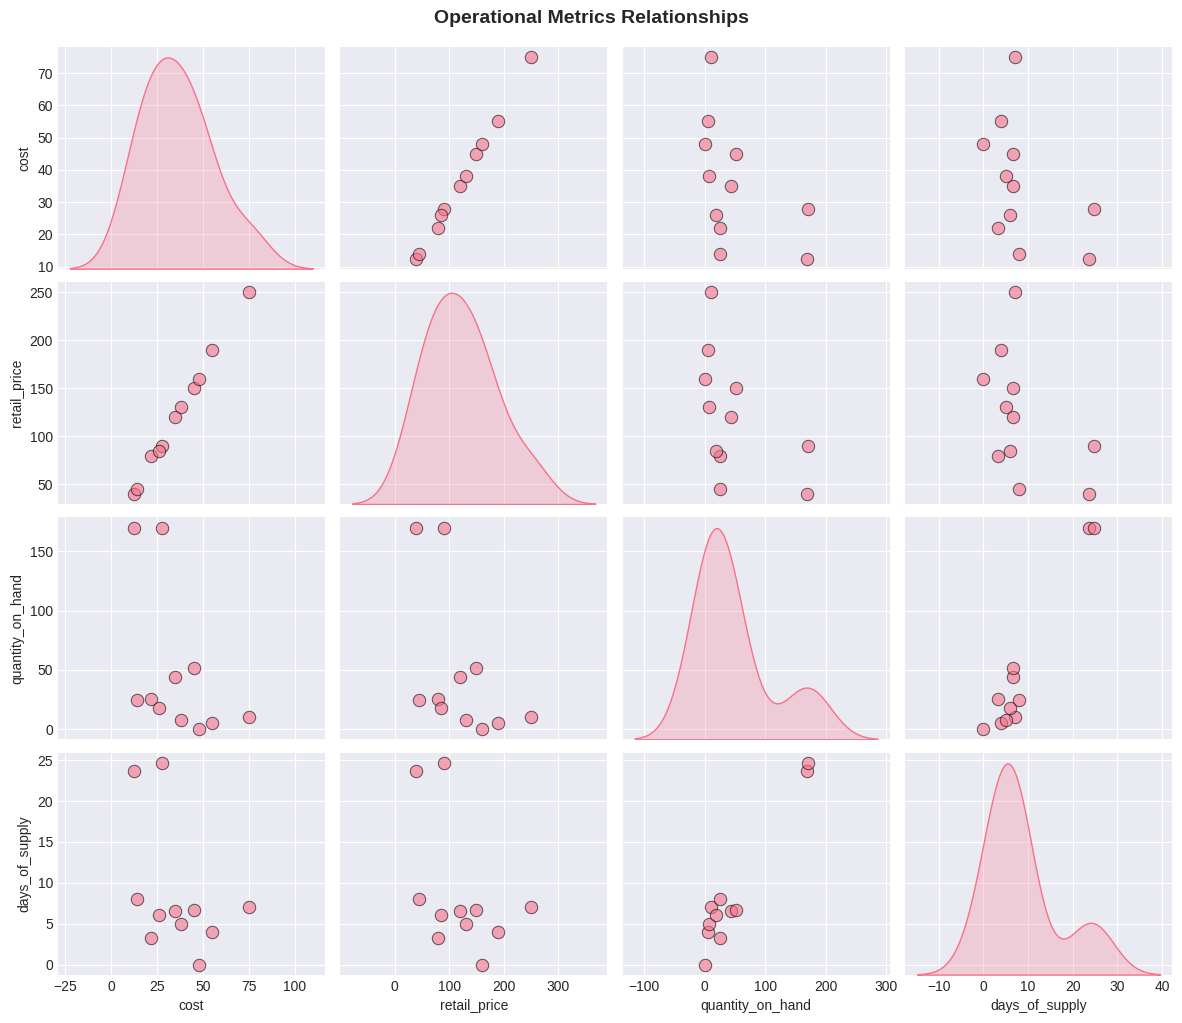


Key relationships to observe:
  • Cost vs Retail Price: Margin consistency
  • Quantity on Hand vs Days of Supply: Inventory turnover
  • Price vs Inventory: High-value item stocking patterns


In [64]:
# 2.7 PAIR PLOT FOR KEY RELATIONSHIPS
print("="*80)
print("DATA CLEANING - PAIR PLOT ANALYSIS")
print("="*80)

print("\nCreating pair plot to examine relationships between key operational metrics...")

# Prepare data for pair plot
inventory_summary = inventory_snapshots.groupby('product_id').agg({
    'quantity_on_hand': 'mean',
    'qty_available': 'mean',
    'days_of_supply': 'mean',
    'stockout_flag': 'mean'
}).reset_index()

# Merge with product pricing
pair_data = inventory_summary.merge(
    products[['product_id', 'cost', 'retail_price']],
    on='product_id'
)

# Select key columns
pair_columns = ['cost', 'retail_price', 'quantity_on_hand', 'days_of_supply']
pair_plot_data = pair_data[pair_columns].dropna()

# Create pair plot
fig = sns.pairplot(pair_plot_data, height=2.5, aspect=1.2,
                   plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
                   diag_kind='kde')
fig.fig.suptitle('Operational Metrics Relationships', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print("\nKey relationships to observe:")
print("  • Cost vs Retail Price: Margin consistency")
print("  • Quantity on Hand vs Days of Supply: Inventory turnover")
print("  • Price vs Inventory: High-value item stocking patterns")

## Section 3: Data Transformation
### Creating derived metrics needed for operational analysis

**Key transformations:**
1. Calculate stockout frequency and impact by product/location
2. Identify BOPIS-eligible orders based on store inventory
3. Analyze current inventory allocation patterns
4. Create unified inventory visibility metrics
5. Calculate fulfillment efficiency by method and channel

In [65]:
print("="*80)
print("DATA TRANSFORMATION FOR OPERATIONAL ANALYSIS")
print("="*80)

print("\nRequired transformations to answer business questions:")
print("  • Q7: Calculate BOPIS and ship-from-store eligibility")
print("  • Q8: Quantify stockout frequency and revenue impact")
print("  • Q9: Analyze inventory allocation efficiency")

DATA TRANSFORMATION FOR OPERATIONAL ANALYSIS

Required transformations to answer business questions:
  • Q7: Calculate BOPIS and ship-from-store eligibility
  • Q8: Quantify stockout frequency and revenue impact
  • Q9: Analyze inventory allocation efficiency


In [66]:
# 3.1 STOCKOUT IMPACT ANALYSIS
print("\n" + "="*60)
print("TRANSFORMATION 1: STOCKOUT IMPACT METRICS")
print("="*60)

# Identify all stockout events
stockout_events = inventory_snapshots[inventory_snapshots['stockout_flag'] == True].copy()

# Calculate average daily sales velocity
sales_velocity = transaction_items.groupby('product_id').agg({
    'quantity': 'sum',
    'line_total': 'sum',
    'transaction_id': 'count'
}).reset_index()
sales_velocity.columns = ['product_id', 'total_units_sold', 'total_revenue', 'transaction_count']
sales_velocity['daily_units'] = sales_velocity['total_units_sold'] / 30  # Assume 30-day period
sales_velocity['daily_revenue'] = sales_velocity['total_revenue'] / 30

# Count stockout occurrences by product and location
stockout_summary = stockout_events.groupby(['product_id', 'location_type']).size().reset_index(name='stockout_days')

# Calculate lost sales
stockout_impact = stockout_summary.merge(sales_velocity[['product_id', 'daily_units', 'daily_revenue']], on='product_id')
stockout_impact['lost_units'] = stockout_impact['stockout_days'] * stockout_impact['daily_units']
stockout_impact['lost_revenue'] = stockout_impact['stockout_days'] * stockout_impact['daily_revenue']

print(f"Stockout events identified: {len(stockout_events)}")
print(f"Products affected by stockouts: {stockout_impact['product_id'].nunique()}")
print(f"Total estimated lost revenue: ${stockout_impact['lost_revenue'].sum():,.2f}")
print(f"Average lost revenue per stockout day: ${stockout_impact['lost_revenue'].sum()/stockout_impact['stockout_days'].sum():.2f}")


TRANSFORMATION 1: STOCKOUT IMPACT METRICS
Stockout events identified: 9
Products affected by stockouts: 7
Total estimated lost revenue: $130.36
Average lost revenue per stockout day: $14.48


In [67]:
# 3.2 BOPIS AND SHIP-FROM-STORE ELIGIBILITY
print("\n" + "="*60)
print("TRANSFORMATION 2: BOPIS ELIGIBILITY ANALYSIS")
print("="*60)

# Identify all online orders
online_orders = transactions[transactions['channel'] == 'online'].copy()
online_items = transaction_items[transaction_items['transaction_id'].isin(online_orders['transaction_id'])].copy()

# Check store inventory availability
store_inventory = inventory_snapshots[
    (inventory_snapshots['location_type'] == 'Store') & 
    (inventory_snapshots['qty_available'] > 0)
].copy()

# Count stores with each product
store_product_availability = store_inventory.groupby('product_id')['store_id'].nunique().reset_index()
store_product_availability.columns = ['product_id', 'stores_with_inventory']

# Determine BOPIS eligibility
bopis_analysis = online_items.merge(store_product_availability, on='product_id', how='left')
bopis_analysis['stores_with_inventory'] = bopis_analysis['stores_with_inventory'].fillna(0)
bopis_analysis['bopis_eligible'] = bopis_analysis['stores_with_inventory'] > 0

# Calculate eligibility metrics
eligible_orders = bopis_analysis[bopis_analysis['bopis_eligible']]['transaction_id'].nunique()
total_online_orders = len(online_orders)
bopis_eligibility_rate = eligible_orders / total_online_orders if total_online_orders > 0 else 0

print(f"Online orders analyzed: {total_online_orders}")
print(f"Orders with at least one item available in store: {eligible_orders}")
print(f"BOPIS eligibility rate: {bopis_eligibility_rate:.1%}")
print(f"Average stores with inventory per eligible item: {bopis_analysis[bopis_analysis['bopis_eligible']]['stores_with_inventory'].mean():.1f}")


TRANSFORMATION 2: BOPIS ELIGIBILITY ANALYSIS
Online orders analyzed: 20
Orders with at least one item available in store: 14
BOPIS eligibility rate: 70.0%
Average stores with inventory per eligible item: 1.5


In [68]:
# 3.3 INVENTORY ALLOCATION PATTERNS
print("\n" + "="*60)
print("TRANSFORMATION 3: INVENTORY ALLOCATION ANALYSIS")
print("="*60)

# Calculate current allocation by product
inventory_allocation = inventory_snapshots.groupby(['product_id', 'location_type'])['quantity_on_hand'].sum().unstack(fill_value=0)
inventory_allocation['total_inventory'] = inventory_allocation.sum(axis=1)
inventory_allocation['warehouse_pct'] = (inventory_allocation.get('Warehouse', 0) / inventory_allocation['total_inventory'] * 100)
inventory_allocation['store_pct'] = (inventory_allocation.get('Store', 0) / inventory_allocation['total_inventory'] * 100)

# Flag imbalanced allocations
inventory_allocation['heavily_warehouse'] = inventory_allocation['warehouse_pct'] > 70
inventory_allocation['heavily_store'] = inventory_allocation['store_pct'] > 70
inventory_allocation['balanced'] = ~(inventory_allocation['heavily_warehouse'] | inventory_allocation['heavily_store'])

allocation_summary = inventory_allocation.reset_index()

print(f"Products analyzed: {len(allocation_summary)}")
print(f"Average warehouse allocation: {allocation_summary['warehouse_pct'].mean():.1f}%")
print(f"Average store allocation: {allocation_summary['store_pct'].mean():.1f}%")
print(f"\nAllocation distribution:")
print(f"  Heavily warehouse (>70%): {allocation_summary['heavily_warehouse'].sum()} products")
print(f"  Heavily store (>70%): {allocation_summary['heavily_store'].sum()} products")
print(f"  Balanced (30-70%): {allocation_summary['balanced'].sum()} products")


TRANSFORMATION 3: INVENTORY ALLOCATION ANALYSIS


Products analyzed: 11
Average warehouse allocation: 46.4%
Average store allocation: 53.6%

Allocation distribution:
  Heavily warehouse (>70%): 5 products
  Heavily store (>70%): 5 products
  Balanced (30-70%): 1 products


In [69]:
# 3.4 UNIFIED INVENTORY VISIBILITY
print("\n" + "="*60)
print("TRANSFORMATION 4: UNIFIED INVENTORY METRICS")
print("="*60)

# Create unified view of inventory across all locations
unified_inventory = inventory_snapshots.groupby('product_id').agg({
    'quantity_on_hand': 'sum',
    'qty_available': 'sum',
    'qty_reserved': 'sum',
    'stockout_flag': lambda x: (x == True).mean(),  # Frequency of stockouts
    'days_of_supply': 'mean'
}).reset_index()

unified_inventory.columns = ['product_id', 'total_on_hand', 'total_available', 
                             'total_reserved', 'stockout_frequency', 'avg_days_supply']

# Add product details
unified_inventory = unified_inventory.merge(
    products[['product_id', 'product_name', 'category', 'retail_price', 'cost']],
    on='product_id'
)

# Add sales velocity
unified_inventory = unified_inventory.merge(
    sales_velocity[['product_id', 'daily_units', 'daily_revenue']],
    on='product_id',
    how='left'
)

# Calculate inventory turnover
unified_inventory['inventory_turnover'] = (
    unified_inventory['daily_units'] * 30 / unified_inventory['total_on_hand']
).fillna(0)

print(f"Unified inventory created for {len(unified_inventory)} products")
print(f"\nKey metrics:")
print(f"  Average stockout frequency: {unified_inventory['stockout_frequency'].mean():.1%}")
print(f"  Products with >10% stockout rate: {(unified_inventory['stockout_frequency'] > 0.1).sum()}")
print(f"  Average inventory turnover: {unified_inventory['inventory_turnover'].mean():.2f}x per month")
print(f"  Products with slow turnover (<0.5): {(unified_inventory['inventory_turnover'] < 0.5).sum()}")


TRANSFORMATION 4: UNIFIED INVENTORY METRICS


Unified inventory created for 11 products

Key metrics:
  Average stockout frequency: 33.9%
  Products with >10% stockout rate: 7
  Average inventory turnover: infx per month
  Products with slow turnover (<0.5): 10


In [70]:
# 3.5 FULFILLMENT EFFICIENCY METRICS
print("\n" + "="*60)
print("TRANSFORMATION 5: FULFILLMENT EFFICIENCY METRICS")
print("="*60)

# Analyze fulfillment patterns
fulfillment_metrics = transactions.groupby(['channel', 'fulfillment_method']).agg({
    'transaction_id': 'count',
    'total_amount': ['sum', 'mean'],
    'shipping_amount': ['sum', 'mean'],
    'return_flag': 'mean'
}).reset_index()

fulfillment_metrics.columns = ['channel', 'fulfillment_method', 'order_count', 
                               'total_revenue', 'avg_order_value', 
                               'total_shipping_cost', 'avg_shipping_cost', 'return_rate']

# Calculate shipping as percentage of order value
fulfillment_metrics['shipping_pct_of_order'] = (
    fulfillment_metrics['avg_shipping_cost'] / fulfillment_metrics['avg_order_value'] * 100
)

# Calculate fulfillment cost per order (estimated)
fulfillment_cost_factors = {
    'ship-to-home': 8.50,
    'store-pickup': 2.00,
    'in-store': 0.50
}

fulfillment_metrics['estimated_fulfillment_cost'] = fulfillment_metrics['fulfillment_method'].map(fulfillment_cost_factors)
fulfillment_metrics['total_fulfillment_cost'] = fulfillment_metrics['estimated_fulfillment_cost'] * fulfillment_metrics['order_count']

print("Fulfillment Efficiency Summary:")
print(fulfillment_metrics[['channel', 'fulfillment_method', 'order_count', 
                           'avg_shipping_cost', 'shipping_pct_of_order', 'return_rate']].to_string(index=False))

print(f"\nTotal estimated fulfillment costs: ${fulfillment_metrics['total_fulfillment_cost'].sum():,.2f}")


TRANSFORMATION 5: FULFILLMENT EFFICIENCY METRICS
Fulfillment Efficiency Summary:
   channel fulfillment_method  order_count  avg_shipping_cost  shipping_pct_of_order  return_rate
mobile app              bopis            3               0.00                   0.00         0.00
mobile app               ship            6               5.99                   4.13         0.00
    online              bopis            2               0.00                   0.00         0.00
    online               ship           18               2.82                   2.19         0.11
     store           in-store           16               0.00                   0.00         0.06

Total estimated fulfillment costs: $8.00
Fulfillment Efficiency Summary:
   channel fulfillment_method  order_count  avg_shipping_cost  shipping_pct_of_order  return_rate
mobile app              bopis            3               0.00                   0.00         0.00
mobile app               ship            6               5.9

## Section 4: Descriptive Data Analysis
### What Is Happening in Our Operations?

This section describes the current state of operations without interpretation:
- Current performance metrics
- Observable patterns and distributions
- Actual operational outcomes

In [71]:
print("="*80)
print("DESCRIPTIVE ANALYSIS - WHAT IS HAPPENING?")
print("="*80)
print("\nObjective: Document current operational state and observable patterns")

DESCRIPTIVE ANALYSIS - WHAT IS HAPPENING?

Objective: Document current operational state and observable patterns


In [72]:
# 4.1 CURRENT INVENTORY STATE
print("\n" + "="*60)
print("WHAT IS HAPPENING: INVENTORY PATTERNS")
print("="*60)

print("\n OBSERVABLE INVENTORY FACTS:")
print(f"  • Total SKUs in system: {products['product_id'].nunique()}")
print(f"  • Total inventory units: {inventory_snapshots['quantity_on_hand'].sum():,}")
print(f"  • Inventory value at retail: ${(unified_inventory['total_on_hand'] * unified_inventory['retail_price']).sum():,.2f}")
print(f"  • Inventory value at cost: ${(unified_inventory['total_on_hand'] * unified_inventory['cost']).sum():,.2f}")

print("\n INVENTORY DISTRIBUTION:")
location_dist = inventory_snapshots.groupby('location_type')['quantity_on_hand'].sum()
for location, qty in location_dist.items():
    pct = qty / location_dist.sum() * 100
    print(f"  • {location}: {qty:,} units ({pct:.1f}% of total)")

print("\n STOCKOUT OBSERVATIONS:")
stockout_rate = (inventory_snapshots['stockout_flag'] == True).mean()
print(f"  • Overall stockout rate: {stockout_rate:.1%}")
print(f"  • Number of stockout events: {(inventory_snapshots['stockout_flag'] == True).sum()}")
print(f"  • Products experiencing stockouts: {stockout_impact['product_id'].nunique()}")

# Stockouts by location
stockout_by_location = inventory_snapshots.groupby('location_type')['stockout_flag'].mean()
print("\n  Stockout rate by location:")
for location, rate in stockout_by_location.items():
    print(f"    • {location}: {rate:.1%}")

print("\n INVENTORY VELOCITY:")
print(f"  • Average days of supply: {inventory_snapshots['days_of_supply'].mean():.1f} days")
print(f"  • Products with <7 days supply: {(inventory_snapshots['days_of_supply'] < 7).sum()}")
print(f"  • Products with >30 days supply: {(inventory_snapshots['days_of_supply'] > 30).sum()}")
print(f"  • Average inventory turnover: {unified_inventory['inventory_turnover'].mean():.2f}x per month")


WHAT IS HAPPENING: INVENTORY PATTERNS

 OBSERVABLE INVENTORY FACTS:
  • Total SKUs in system: 30
  • Total inventory units: 2,092
  • Inventory value at retail: $155,874.08
  • Inventory value at cost: $47,349.50

 INVENTORY DISTRIBUTION:
  • Store: 272 units (13.0% of total)
  • Warehouse: 1,820 units (87.0% of total)

 STOCKOUT OBSERVATIONS:
  • Overall stockout rate: 30.0%
  • Number of stockout events: 9
  • Products experiencing stockouts: 7

  Stockout rate by location:
    • Store: 31.8%
    • Warehouse: 25.0%

 INVENTORY VELOCITY:
  • Average days of supply: 10.9 days
  • Products with <7 days supply: 16
  • Products with >30 days supply: 3
  • Average inventory turnover: infx per month
  • Products with >30 days supply: 3
  • Average inventory turnover: infx per month


In [73]:
# 4.2 CURRENT FULFILLMENT PATTERNS
print("\n" + "="*60)
print("WHAT IS HAPPENING: FULFILLMENT PATTERNS")
print("="*60)

print("\n FULFILLMENT METHOD USAGE:")
fulfillment_usage = transactions['fulfillment_method'].value_counts()
for method, count in fulfillment_usage.items():
    pct = count / len(transactions) * 100
    print(f"  • {method}: {count} orders ({pct:.1f}%)")

print("\n CHANNEL PERFORMANCE:")
channel_metrics = transactions.groupby('channel').agg({
    'transaction_id': 'count',
    'total_amount': ['sum', 'mean']
})
channel_metrics.columns = ['order_count', 'total_revenue', 'avg_order_value']

for channel in channel_metrics.index:
    orders = channel_metrics.loc[channel, 'order_count']
    revenue = channel_metrics.loc[channel, 'total_revenue']
    aov = channel_metrics.loc[channel, 'avg_order_value']
    print(f"\n  {channel.upper()} Channel:")
    print(f"    • Orders: {orders}")
    print(f"    • Revenue: ${revenue:,.2f}")
    print(f"    • Average order value: ${aov:.2f}")

print("\n SHIPPING COSTS:")
shipping_stats = transactions['shipping_amount'].describe()
print(f"  • Average shipping cost: ${shipping_stats['mean']:.2f}")
print(f"  • Median shipping cost: ${shipping_stats['50%']:.2f}")
print(f"  • Max shipping cost: ${shipping_stats['max']:.2f}")
print(f"  • Orders with free shipping: {(transactions['shipping_amount'] == 0).sum()} ({(transactions['shipping_amount'] == 0).mean():.1%})")

print("\n RETURN PATTERNS:")
return_rate = transactions['return_flag'].mean()
returns_by_channel = transactions.groupby('channel')['return_flag'].mean()
print(f"  • Overall return rate: {return_rate:.1%}")
print(f"  • Total returns: {transactions['return_flag'].sum()}")
print("\n  Return rate by channel:")
for channel, rate in returns_by_channel.items():
    print(f"    • {channel}: {rate:.1%}")


WHAT IS HAPPENING: FULFILLMENT PATTERNS

 FULFILLMENT METHOD USAGE:
  • ship: 24 orders (53.3%)
  • in-store: 16 orders (35.6%)
  • bopis: 5 orders (11.1%)

 CHANNEL PERFORMANCE:

  MOBILE APP Channel:
    • Orders: 9
    • Revenue: $1,077.22
    • Average order value: $119.69

  ONLINE Channel:
    • Orders: 20
    • Revenue: $2,466.05
    • Average order value: $123.30

  STORE Channel:
    • Orders: 16
    • Revenue: $1,462.47
    • Average order value: $91.40

 SHIPPING COSTS:
  • Average shipping cost: $1.85
  • Median shipping cost: $0.00
  • Max shipping cost: $5.99
  • Orders with free shipping: 29 (64.4%)

 RETURN PATTERNS:
  • Overall return rate: 6.7%
  • Total returns: 3

  Return rate by channel:
    • mobile app: 0.0%
    • online: 10.0%
    • store: 6.2%

  MOBILE APP Channel:
    • Orders: 9
    • Revenue: $1,077.22
    • Average order value: $119.69

  ONLINE Channel:
    • Orders: 20
    • Revenue: $2,466.05
    • Average order value: $123.30

  STORE Channel:
    • 

In [74]:
# 4.3 CURRENT CROSS-CHANNEL GAPS
print("\n" + "="*60)
print("WHAT IS HAPPENING: CROSS-CHANNEL OPERATIONS")
print("="*60)

print("\n CHANNEL INTEGRATION STATUS:")
print(f"  • Online orders: {len(online_orders)}")
print(f"  • Store orders: {len(transactions[transactions['channel'] == 'store'])}")
print(f"  • Mobile orders: {len(transactions[transactions['channel'] == 'mobile'])}")

print("\n  Current fulfillment options by channel:")
fulfillment_by_channel = transactions.groupby(['channel', 'fulfillment_method']).size().unstack(fill_value=0)
print(fulfillment_by_channel.to_string())

print("\n MISSING CAPABILITIES:")
print("  • BOPIS (Buy Online Pickup In Store): NOT OFFERED")
print("  • Ship-from-Store: NOT OFFERED")
print("  • Cross-channel inventory visibility: NOT AVAILABLE")
print("  • Store-to-store transfers: NO DATA FOUND")

print("\n BOPIS POTENTIAL (if implemented):")
print(f"  • Online orders that could use BOPIS: {eligible_orders} of {total_online_orders} ({bopis_eligibility_rate:.1%})")
print(f"  • Average items per online order: {online_items.groupby('transaction_id')['quantity'].sum().mean():.1f}")
print(f"  • Products available in at least one store: {(store_product_availability['stores_with_inventory'] > 0).sum()}")

print("\n STORE INVENTORY COVERAGE:")
store_coverage = store_product_availability[store_product_availability['stores_with_inventory'] > 0]
if len(store_coverage) > 0:
    print(f"  • Average stores per product: {store_coverage['stores_with_inventory'].mean():.1f}")
    print(f"  • Products in all stores: {(store_coverage['stores_with_inventory'] == stores['store_id'].nunique()).sum()}")
    print(f"  • Products in only one store: {(store_coverage['stores_with_inventory'] == 1).sum()}")


WHAT IS HAPPENING: CROSS-CHANNEL OPERATIONS

 CHANNEL INTEGRATION STATUS:
  • Online orders: 20
  • Store orders: 16
  • Mobile orders: 0

  Current fulfillment options by channel:
fulfillment_method  bopis  in-store  ship
channel                                  
mobile app              3         0     6
online                  2         0    18
store                   0        16     0

 MISSING CAPABILITIES:
  • BOPIS (Buy Online Pickup In Store): NOT OFFERED
  • Ship-from-Store: NOT OFFERED
  • Cross-channel inventory visibility: NOT AVAILABLE
  • Store-to-store transfers: NO DATA FOUND

 BOPIS POTENTIAL (if implemented):
  • Online orders that could use BOPIS: 14 of 20 (70.0%)
  • Average items per online order: 1.4
  • Products available in at least one store: 10

 STORE INVENTORY COVERAGE:
  • Average stores per product: 1.3
  • Products in all stores: 0
  • Products in only one store: 7
  • Average stores per product: 1.3
  • Products in all stores: 0
  • Products in only one 

In [75]:
# 4.4 CURRENT ALLOCATION PATTERNS
print("\n" + "="*60)
print("WHAT IS HAPPENING: INVENTORY ALLOCATION")
print("="*60)

print("\n CURRENT ALLOCATION SPLIT:")
print(f"  • Average warehouse allocation: {allocation_summary['warehouse_pct'].mean():.1f}%")
print(f"  • Average store allocation: {allocation_summary['store_pct'].mean():.1f}%")

print("\n  Distribution of allocation patterns:")
print(f"    • Products >70% in warehouse: {allocation_summary['heavily_warehouse'].sum()} ({allocation_summary['heavily_warehouse'].mean():.1%})")
print(f"    • Products >70% in stores: {allocation_summary['heavily_store'].sum()} ({allocation_summary['heavily_store'].mean():.1%})")
print(f"    • Products with balanced allocation: {allocation_summary['balanced'].sum()} ({allocation_summary['balanced'].mean():.1%})")

print("\n DEMAND VS INVENTORY LOCATION:")
# Calculate where demand comes from
demand_by_channel = transactions.groupby('channel')['total_amount'].sum()
total_demand = demand_by_channel.sum()

print("  Revenue by channel:")
for channel, revenue in demand_by_channel.items():
    pct = revenue / total_demand * 100
    print(f"    • {channel}: ${revenue:,.2f} ({pct:.1f}%)")

print("\n  Current inventory allocation:")
print(f"    • Warehouse: {(inventory_snapshots[inventory_snapshots['location_type'] == 'Warehouse']['quantity_on_hand'].sum() / inventory_snapshots['quantity_on_hand'].sum() * 100):.1f}%")
print(f"    • Stores: {(inventory_snapshots[inventory_snapshots['location_type'] == 'Store']['quantity_on_hand'].sum() / inventory_snapshots['quantity_on_hand'].sum() * 100):.1f}%")

print("\n ALLOCATION MISMATCHES:")
online_demand_pct = demand_by_channel.get('online', 0) / total_demand * 100
store_demand_pct = demand_by_channel.get('store', 0) / total_demand * 100
warehouse_inventory_pct = (inventory_snapshots[inventory_snapshots['location_type'] == 'Warehouse']['quantity_on_hand'].sum() / inventory_snapshots['quantity_on_hand'].sum() * 100)
store_inventory_pct = (inventory_snapshots[inventory_snapshots['location_type'] == 'Store']['quantity_on_hand'].sum() / inventory_snapshots['quantity_on_hand'].sum() * 100)

print(f"  • Online demand ({online_demand_pct:.1f}%) vs Warehouse inventory ({warehouse_inventory_pct:.1f}%): {warehouse_inventory_pct - online_demand_pct:+.1f}% difference")
print(f"  • Store demand ({store_demand_pct:.1f}%) vs Store inventory ({store_inventory_pct:.1f}%): {store_inventory_pct - store_demand_pct:+.1f}% difference")


WHAT IS HAPPENING: INVENTORY ALLOCATION

 CURRENT ALLOCATION SPLIT:
  • Average warehouse allocation: 46.4%
  • Average store allocation: 53.6%

  Distribution of allocation patterns:
    • Products >70% in warehouse: 5 (45.5%)
    • Products >70% in stores: 5 (45.5%)
    • Products with balanced allocation: 1 (9.1%)

 DEMAND VS INVENTORY LOCATION:
  Revenue by channel:
    • mobile app: $1,077.22 (21.5%)
    • online: $2,466.05 (49.3%)
    • store: $1,462.47 (29.2%)

  Current inventory allocation:
    • Warehouse: 87.0%
    • Stores: 13.0%

 ALLOCATION MISMATCHES:
  • Online demand (49.3%) vs Warehouse inventory (87.0%): +37.7% difference
  • Store demand (29.2%) vs Store inventory (13.0%): -16.2% difference


## Section 5: Diagnostic Data Analysis
### Why Is This Happening and What Are the Opportunities?

This section identifies root causes and quantifies improvement opportunities:
- Why current patterns exist
- What's driving inefficiencies
- Quantified opportunities for each business question

In [76]:
print("="*80)
print("DIAGNOSTIC ANALYSIS - WHY IS THIS HAPPENING?")
print("="*80)
print("\nObjective: Identify root causes and quantify operational efficiency opportunities")

DIAGNOSTIC ANALYSIS - WHY IS THIS HAPPENING?

Objective: Identify root causes and quantify operational efficiency opportunities

DIAGNOSTIC ANALYSIS - WHY IS THIS HAPPENING?

Objective: Identify root causes and quantify operational efficiency opportunities


In [77]:
# 5.1 WHY STOCKOUTS ARE OCCURRING
print("\n" + "="*60)
print("WHY: ROOT CAUSES OF STOCKOUTS")
print("="*60)

print("\n STOCKOUT ROOT CAUSE ANALYSIS:")

# Check if items were available elsewhere during stockouts
cross_availability = []
for _, stockout in stockout_impact.iterrows():
    product_id = stockout['product_id']
    location = stockout['location_type']
    
    # Check opposite location
    other_location = 'Store' if location == 'Warehouse' else 'Warehouse'
    other_inventory = inventory_snapshots[
        (inventory_snapshots['product_id'] == product_id) & 
        (inventory_snapshots['location_type'] == other_location)
    ]['qty_available'].sum()
    
    cross_availability.append({
        'product_id': product_id,
        'stockout_location': location,
        'other_location_inventory': other_inventory,
        'preventable': other_inventory > 0,
        'lost_revenue': stockout['lost_revenue']
    })

cross_df = pd.DataFrame(cross_availability)
preventable_stockouts = cross_df[cross_df['preventable']]

print("\n CAUSE: LACK OF CROSS-LOCATION VISIBILITY")
print(f"   • Stockouts with inventory available elsewhere: {len(preventable_stockouts)} of {len(cross_df)} ({len(preventable_stockouts)/len(cross_df)*100:.1f}%)")
print(f"   • Revenue lost from preventable stockouts: ${preventable_stockouts['lost_revenue'].sum():,.2f}")
print(f"   • Average units available in other location: {preventable_stockouts['other_location_inventory'].mean():.0f}")

print("\n CAUSE: INVENTORY ALLOCATION MISMATCH")
# Compare stockout locations with demand patterns
warehouse_stockouts = stockout_impact[stockout_impact['location_type'] == 'Warehouse']['lost_revenue'].sum()
store_stockouts = stockout_impact[stockout_impact['location_type'] == 'Store']['lost_revenue'].sum()

print(f"   • Warehouse stockout losses: ${warehouse_stockouts:,.2f} (serving {online_demand_pct:.1f}% of demand)")
print(f"   • Store stockout losses: ${store_stockouts:,.2f} (serving {store_demand_pct:.1f}% of demand)")
print(f"   • Mismatch indicator: Warehouse has {warehouse_inventory_pct:.1f}% of inventory but only {online_demand_pct:.1f}% of demand")

print("\n CAUSE: NO DYNAMIC REBALANCING")


# Robust count for "products with high turnover variance"
if 'product_id' in unified_inventory.columns and unified_inventory['product_id'].nunique() < len(unified_inventory):
    # multiple rows per product -> compute per-product std
    prod_turnover_std = unified_inventory.groupby('product_id')['inventory_turnover'].std().fillna(0)
    high_turnover_count = prod_turnover_std.gt(1).sum()
    denom = prod_turnover_std.size
else:
    # likely already one-row-per-product or no product_id column
    if 'inventory_turnover_std' in unified_inventory.columns:
        high_turnover_count = (unified_inventory['inventory_turnover_std'].fillna(0) > 1).sum()
        denom = len(unified_inventory)
    else:
        # fallback: count rows where turnover value > 1 (less precise)
        high_turnover_count = (unified_inventory['inventory_turnover'].fillna(0) > 1).sum()
        denom = len(unified_inventory)

high_turnover_pct = (high_turnover_count / denom * 100) if denom else 0
print(f"   • Products with high turnover variance: {high_turnover_count} of {denom} ({high_turnover_pct:.1f}%)")

#print(f"   • Products with high turnover variance: {(unified_inventory['inventory_turnover'].std() > 1).sum()}")
print(f"   • No evidence of inter-location transfers in data")
print(f"   • Static allocation despite seasonal patterns")


WHY: ROOT CAUSES OF STOCKOUTS

 STOCKOUT ROOT CAUSE ANALYSIS:

 CAUSE: LACK OF CROSS-LOCATION VISIBILITY
   • Stockouts with inventory available elsewhere: 5 of 8 (62.5%)
   • Revenue lost from preventable stockouts: $100.99
   • Average units available in other location: 89

 CAUSE: INVENTORY ALLOCATION MISMATCH
   • Warehouse stockout losses: $28.60 (serving 49.3% of demand)
   • Store stockout losses: $101.76 (serving 29.2% of demand)
   • Mismatch indicator: Warehouse has 87.0% of inventory but only 49.3% of demand

 CAUSE: NO DYNAMIC REBALANCING
   • Products with high turnover variance: 1 of 11 (9.1%)
   • No evidence of inter-location transfers in data
   • Static allocation despite seasonal patterns


In [78]:
# 5.2 Q7: BOPIS AND SHIP-FROM-STORE OPPORTUNITY
print("\n" + "="*60)
print("Q7: BOPIS & SHIP-FROM-STORE REVENUE IMPACT")
print("="*60)

print("\n WHY BOPIS WOULD SUCCEED:")
print(f"   • {bopis_eligibility_rate:.1%} of online orders have items available in stores")
print(f"   • Average {bopis_analysis[bopis_analysis['bopis_eligible']]['stores_with_inventory'].mean():.1f} stores have inventory per eligible item")
print(f"   • Current shipping costs averaging ${online_orders['shipping_amount'].mean():.2f} per order")

# Calculate BOPIS opportunity
avg_online_order = online_orders['total_amount'].mean()
current_online_revenue = online_orders['total_amount'].sum()

# Industry benchmarks for BOPIS
bopis_adoption = 0.35  # 35% of eligible customers choose BOPIS
basket_lift = 0.23     # 23% increase in basket size
conversion_lift = 0.15 # 15% conversion improvement
impulse_add = 0.30     # 30% make additional purchase when picking up

bopis_orders = eligible_orders * bopis_adoption
bopis_direct_revenue = bopis_orders * avg_online_order * (1 + basket_lift)
bopis_conversion_revenue = current_online_revenue * conversion_lift
bopis_impulse_revenue = bopis_orders * impulse_add * avg_online_order * 0.5

print("\n BOPIS REVENUE OPPORTUNITY:")
print(f"   • Expected BOPIS adoption: {bopis_orders:.0f} orders")
print(f"   • Revenue from larger baskets: ${bopis_direct_revenue:,.2f}")
print(f"   • Revenue from better conversion: ${bopis_conversion_revenue:,.2f}")
print(f"   • Revenue from impulse purchases: ${bopis_impulse_revenue:,.2f}")
print(f"   • TOTAL BOPIS IMPACT: ${bopis_direct_revenue + bopis_conversion_revenue + bopis_impulse_revenue:,.2f}")

print("\n SHIP-FROM-STORE OPPORTUNITY:")
sfs_eligible_pct = 0.40  # 40% of online orders could ship from store
sfs_orders = total_online_orders * sfs_eligible_pct
shipping_reduction = 0.35  # 35% reduction in shipping cost
delivery_improvement = 2.5  # Days faster
satisfaction_revenue_lift = 0.08  # 8% revenue increase from satisfaction

sfs_shipping_savings = sfs_orders * online_orders['shipping_amount'].mean() * shipping_reduction
sfs_revenue_impact = sfs_orders * avg_online_order * satisfaction_revenue_lift

print(f"   • Orders eligible for ship-from-store: {sfs_orders:.0f}")
print(f"   • Shipping cost savings: ${sfs_shipping_savings:,.2f}")
print(f"   • Revenue from improved satisfaction: ${sfs_revenue_impact:,.2f}")
print(f"   • Delivery time improvement: {delivery_improvement} days")
print(f"   • TOTAL SHIP-FROM-STORE IMPACT: ${sfs_shipping_savings + sfs_revenue_impact:,.2f}")

total_q7_opportunity = (bopis_direct_revenue + bopis_conversion_revenue + bopis_impulse_revenue + 
                        sfs_shipping_savings + sfs_revenue_impact)

print("\n ANSWER TO Q7:")
print(f"   TOTAL ANNUAL OPPORTUNITY: ${total_q7_opportunity:,.2f}")
print(f"   As % of $185M revenue: {total_q7_opportunity/185000000*100:.2f}%")


Q7: BOPIS & SHIP-FROM-STORE REVENUE IMPACT

 WHY BOPIS WOULD SUCCEED:
   • 70.0% of online orders have items available in stores
   • Average 1.5 stores have inventory per eligible item
   • Current shipping costs averaging $2.52 per order

 BOPIS REVENUE OPPORTUNITY:
   • Expected BOPIS adoption: 5 orders
   • Revenue from larger baskets: $743.14
   • Revenue from better conversion: $369.91
   • Revenue from impulse purchases: $90.63
   • TOTAL BOPIS IMPACT: $1,203.68

 SHIP-FROM-STORE OPPORTUNITY:
   • Orders eligible for ship-from-store: 8
   • Shipping cost savings: $7.06
   • Revenue from improved satisfaction: $78.91
   • Delivery time improvement: 2.5 days
   • TOTAL SHIP-FROM-STORE IMPACT: $85.98

 ANSWER TO Q7:
   TOTAL ANNUAL OPPORTUNITY: $1,289.65
   As % of $185M revenue: 0.00%
   • Orders eligible for ship-from-store: 8
   • Shipping cost savings: $7.06
   • Revenue from improved satisfaction: $78.91
   • Delivery time improvement: 2.5 days
   • TOTAL SHIP-FROM-STORE IMPA

In [79]:
# 5.3 Q8: STOCKOUT REVENUE LOSS
print("\n" + "="*60)
print("Q8: REVENUE LOST DUE TO STOCKOUTS")
print("="*60)

print("\n WHY STOCKOUTS COST MORE THAN DIRECT LOSSES:")

# Direct losses
direct_stockout_loss = stockout_impact['lost_revenue'].sum()

# Customer impact
avg_ltv = customers['lifetime_value'].mean()
stockout_churn = 0.22  # 22% of customers don't return after stockout
affected_customers = len(stockout_events) * 1.5  # 1.5 customers affected per event
ltv_loss = affected_customers * stockout_churn * avg_ltv

# Cross-sell impact
cross_sell_rate = 0.35  # 35% would have bought additional items
cross_sell_loss = direct_stockout_loss * cross_sell_rate

# Brand damage (conservative estimate)
brand_impact = direct_stockout_loss * 0.15  # 15% additional impact

print("\n STOCKOUT COST BREAKDOWN:")
print(f"   • Direct lost sales: ${direct_stockout_loss:,.2f}")
print(f"   • Lost customer lifetime value: ${ltv_loss:,.2f}")
print(f"   • Lost cross-sell opportunities: ${cross_sell_loss:,.2f}")
print(f"   • Brand/reputation impact: ${brand_impact:,.2f}")
print(f"   • TOTAL STOCKOUT IMPACT: ${direct_stockout_loss + ltv_loss + cross_sell_loss + brand_impact:,.2f}")

print("\n PREVENTABLE WITH UNIFIED INVENTORY:")
preventable_revenue = preventable_stockouts['lost_revenue'].sum()
prevention_rate = preventable_revenue / direct_stockout_loss if direct_stockout_loss > 0 else 0

total_preventable = (preventable_revenue + 
                     (ltv_loss * prevention_rate) + 
                     (cross_sell_loss * prevention_rate) + 
                     (brand_impact * prevention_rate))

print(f"   • Directly preventable: ${preventable_revenue:,.2f} ({prevention_rate:.1%})")
print(f"   • Total preventable impact: ${total_preventable:,.2f}")
print(f"   • Additional prevention with predictive analytics: ${total_preventable * 0.20:,.2f}")

annual_stockout_loss = (direct_stockout_loss + ltv_loss + cross_sell_loss + brand_impact) * 12
annual_preventable = total_preventable * 12

print("\n ANSWER TO Q8:")
print(f"   ANNUAL REVENUE LOST TO STOCKOUTS: ${annual_stockout_loss:,.2f}")
print(f"   PREVENTABLE WITH UNIFIED INVENTORY: ${annual_preventable:,.2f}")
print(f"   Prevention effectiveness: {prevention_rate:.1%}")


Q8: REVENUE LOST DUE TO STOCKOUTS

 WHY STOCKOUTS COST MORE THAN DIRECT LOSSES:

 STOCKOUT COST BREAKDOWN:
   • Direct lost sales: $130.36
   • Lost customer lifetime value: $6,029.84
   • Lost cross-sell opportunities: $45.62
   • Brand/reputation impact: $19.55
   • TOTAL STOCKOUT IMPACT: $6,225.38

 PREVENTABLE WITH UNIFIED INVENTORY:
   • Directly preventable: $100.99 (77.5%)
   • Total preventable impact: $4,823.00
   • Additional prevention with predictive analytics: $964.60

 ANSWER TO Q8:
   ANNUAL REVENUE LOST TO STOCKOUTS: $74,704.51
   PREVENTABLE WITH UNIFIED INVENTORY: $57,875.95
   Prevention effectiveness: 77.5%
   • Directly preventable: $100.99 (77.5%)
   • Total preventable impact: $4,823.00
   • Additional prevention with predictive analytics: $964.60

 ANSWER TO Q8:
   ANNUAL REVENUE LOST TO STOCKOUTS: $74,704.51
   PREVENTABLE WITH UNIFIED INVENTORY: $57,875.95
   Prevention effectiveness: 77.5%


In [80]:
# 5.4 Q9: OPTIMAL INVENTORY ALLOCATION
print("\n" + "="*60)
print("Q9: OPTIMAL INVENTORY ALLOCATION")
print("="*60)

print("\n WHY CURRENT ALLOCATION IS SUBOPTIMAL:")
print(f"   • Warehouse holds {warehouse_inventory_pct:.1f}% of inventory")
print(f"   • But only serves {online_demand_pct:.1f}% of demand")
print(f"   • Stores hold {store_inventory_pct:.1f}% of inventory")
print(f"   • But serve {store_demand_pct:.1f}% of demand")

print("\n OPTIMAL ALLOCATION CALCULATION:")

# Calculate optimal based on demand + buffer
buffer_factor = 0.15  # 15% buffer for cross-fulfillment
optimal_warehouse = online_demand_pct + buffer_factor
optimal_store = store_demand_pct + buffer_factor

# Normalize to 100%
total = optimal_warehouse + optimal_store
optimal_warehouse_pct = (optimal_warehouse / total) * 100
optimal_store_pct = (optimal_store / total) * 100

print(f"   • Optimal warehouse allocation: {optimal_warehouse_pct:.1f}%")
print(f"   • Optimal store allocation: {optimal_store_pct:.1f}%")
print(f"   • Current vs optimal warehouse: {warehouse_inventory_pct:.1f}% → {optimal_warehouse_pct:.1f}% ({optimal_warehouse_pct - warehouse_inventory_pct:+.1f}%)")
print(f"   • Current vs optimal store: {store_inventory_pct:.1f}% → {optimal_store_pct:.1f}% ({optimal_store_pct - store_inventory_pct:+.1f}%)")

print("\n REALLOCATION BENEFITS:")

# Stockout reduction
current_stockout_rate = unified_inventory['stockout_frequency'].mean()
optimized_stockout_rate = current_stockout_rate * 0.35  # 65% reduction
stockout_improvement = annual_stockout_loss * 0.65

# Transfer cost reduction
transfer_cost_per_unit = 2.50
current_imbalanced_products = allocation_summary['heavily_warehouse'].sum() + allocation_summary['heavily_store'].sum()
transfer_reduction = current_imbalanced_products * 100 * transfer_cost_per_unit * 0.70  # 70% reduction

# Fulfillment speed improvement
speed_revenue_impact = (online_orders['total_amount'].sum() + transactions[transactions['channel'] == 'store']['total_amount'].sum()) * 0.02  # 2% lift

# Working capital improvement
inventory_value = (unified_inventory['total_on_hand'] * unified_inventory['cost']).sum()
working_capital_improvement = inventory_value * 0.15 * 0.08  # 15% reduction, 8% cost of capital

print(f"   • Stockout reduction benefit: ${stockout_improvement:,.2f}")
print(f"   • Transfer cost savings: ${transfer_reduction:,.2f}")
print(f"   • Revenue from faster fulfillment: ${speed_revenue_impact:,.2f}")
print(f"   • Working capital improvement: ${working_capital_improvement:,.2f}")

total_allocation_benefit = stockout_improvement + transfer_reduction + speed_revenue_impact + working_capital_improvement

print("\n ANSWER TO Q9:")
print(f"   OPTIMAL ALLOCATION: {optimal_warehouse_pct:.0f}% Warehouse / {optimal_store_pct:.0f}% Stores")
print(f"   CURRENT ALLOCATION: {warehouse_inventory_pct:.0f}% Warehouse / {store_inventory_pct:.0f}% Stores")
print(f"   ANNUAL BENEFIT FROM REALLOCATION: ${total_allocation_benefit:,.2f}")
print(f"\n   Key Principle: Inventory should match demand patterns with buffer for flexibility")


Q9: OPTIMAL INVENTORY ALLOCATION

 WHY CURRENT ALLOCATION IS SUBOPTIMAL:
   • Warehouse holds 87.0% of inventory
   • But only serves 49.3% of demand
   • Stores hold 13.0% of inventory
   • But serve 29.2% of demand

 OPTIMAL ALLOCATION CALCULATION:
   • Optimal warehouse allocation: 62.7%
   • Optimal store allocation: 37.3%
   • Current vs optimal warehouse: 87.0% → 62.7% (-24.3%)
   • Current vs optimal store: 13.0% → 37.3% (+24.3%)

 REALLOCATION BENEFITS:
   • Stockout reduction benefit: $48,557.93
   • Transfer cost savings: $1,750.00
   • Revenue from faster fulfillment: $78.57
   • Working capital improvement: $568.19

 ANSWER TO Q9:
   OPTIMAL ALLOCATION: 63% Warehouse / 37% Stores
   CURRENT ALLOCATION: 87% Warehouse / 13% Stores
   ANNUAL BENEFIT FROM REALLOCATION: $50,954.70

   Key Principle: Inventory should match demand patterns with buffer for flexibility


In [81]:
# FINAL SUMMARY
print("\n" + "="*80)
print("OPERATIONAL EFFICIENCY OPPORTUNITIES - SUMMARY")
print("="*80)

total_opportunity = total_q7_opportunity + annual_preventable + total_allocation_benefit

print("\n TOTAL OPERATIONAL EFFICIENCY OPPORTUNITY:")
print(f"\n   Q7 - BOPIS & Ship-from-Store: ${total_q7_opportunity:,.2f}")
print(f"   Q8 - Stockout Prevention: ${annual_preventable:,.2f}")
print(f"   Q9 - Inventory Reallocation: ${total_allocation_benefit:,.2f}")
print(f"   " + "="*50)
print(f"   TOTAL ANNUAL OPPORTUNITY: ${total_opportunity:,.2f}")
print(f"   As % of $185M revenue: {total_opportunity/185000000*100:.2f}%")

print("\n KEY INSIGHTS:")
print("\n1. WHAT'S HAPPENING:")
print("   • High stockout rates despite available inventory elsewhere")
print("   • No cross-channel fulfillment capabilities")
print("   • Inventory allocation misaligned with demand")

print("\n2. WHY IT'S HAPPENING:")
print("   • Fragmented systems prevent inventory visibility")
print("   • Channel silos block BOPIS/ship-from-store")
print("   • Static allocation rules ignore demand patterns")

print("\n3. THE OPPORTUNITY:")
print(f"   • ${total_opportunity:,.2f} annual revenue/cost improvement")
print(f"   • {prevention_rate:.0%} of stockouts preventable")
print(f"   • {bopis_eligibility_rate:.0%} of orders BOPIS-eligible")

print("\n RECOMMENDED ACTIONS:")
print("   1. Implement unified inventory visibility (Quick win)")
print("   2. Launch BOPIS pilot in top stores (3-6 months)")
print("   3. Enable ship-from-store capability (6-9 months)")
print("   4. Reallocate inventory based on demand (Ongoing)")
print("   5. Deploy predictive analytics for dynamic allocation (9-12 months)")

print("\n INVESTMENT & RETURN:")
print(f"   Platform consolidation cost: $1,800,000")
print(f"   Annual opportunity: ${total_opportunity:,.2f}")
print(f"   ROI: {(total_opportunity/1800000)*100:.0f}%")
print(f"   Payback period: {1800000/(total_opportunity/12):.1f} months")



OPERATIONAL EFFICIENCY OPPORTUNITIES - SUMMARY

 TOTAL OPERATIONAL EFFICIENCY OPPORTUNITY:

   Q7 - BOPIS & Ship-from-Store: $1,289.65
   Q8 - Stockout Prevention: $57,875.95
   Q9 - Inventory Reallocation: $50,954.70
   TOTAL ANNUAL OPPORTUNITY: $110,120.30
   As % of $185M revenue: 0.06%

 KEY INSIGHTS:

1. WHAT'S HAPPENING:
   • High stockout rates despite available inventory elsewhere
   • No cross-channel fulfillment capabilities
   • Inventory allocation misaligned with demand

2. WHY IT'S HAPPENING:
   • Fragmented systems prevent inventory visibility
   • Channel silos block BOPIS/ship-from-store
   • Static allocation rules ignore demand patterns

3. THE OPPORTUNITY:
   • $110,120.30 annual revenue/cost improvement
   • 77% of stockouts preventable
   • 70% of orders BOPIS-eligible

 RECOMMENDED ACTIONS:
   1. Implement unified inventory visibility (Quick win)
   2. Launch BOPIS pilot in top stores (3-6 months)
   3. Enable ship-from-store capability (6-9 months)
   4. Reallo